# Intro
This project aims to identify application protocols using only NetFlow data. NetFlow provides detailed network traffic statistics but lacks direct protocol information. By analyzing flow attributes such as IP addresse ranges, packet count, packet size and durations, the goal is to apply unsupervised learning to automatically infer the underlying application protocols. This approach could help network administrators and security professionals gain deeper insights into traffic patterns and improve network management and security.

# Dependencies

In [1]:
#!pip install seaborn numpy pandas matplotlib scikit-learn tqdm kaggle

In [2]:
#!kaggle datasets download jsrojas/ip-network-traffic-flows-labeled-with-87-apps

In [3]:
#!unzip ip-network-traffic-flows-labeled-with-87-apps.zip

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import permutations 

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold

from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
from sklearn.decomposition import NMF, PCA

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, v_measure_score, \
                            fowlkes_mallows_score, homogeneity_score, completeness_score, make_scorer


# Loading data

Let's start with loading the dataset and examining which fields are present, and what is its size

In [5]:
df = pd.read_csv("./Dataset-Unicauca-Version2-87Atts.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3577296 entries, 0 to 3577295
Data columns (total 87 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Flow.ID                      object 
 1   Source.IP                    object 
 2   Source.Port                  int64  
 3   Destination.IP               object 
 4   Destination.Port             int64  
 5   Protocol                     int64  
 6   Timestamp                    object 
 7   Flow.Duration                int64  
 8   Total.Fwd.Packets            int64  
 9   Total.Backward.Packets       int64  
 10  Total.Length.of.Fwd.Packets  int64  
 11  Total.Length.of.Bwd.Packets  float64
 12  Fwd.Packet.Length.Max        int64  
 13  Fwd.Packet.Length.Min        int64  
 14  Fwd.Packet.Length.Mean       float64
 15  Fwd.Packet.Length.Std        float64
 16  Bwd.Packet.Length.Max        int64  
 17  Bwd.Packet.Length.Min        int64  
 18  Bwd.Packet.Length.Mean       float64
 19  

In [7]:
df.shape

(3577296, 87)

# Data Cleaning

There are a lot of columns in our dataset, it could be that some of them are redundant maybe some have all the same value for all records.

We can find them and remove these out.

In [8]:
unique_values = df.nunique()
redundant_columns = unique_values[unique_values == 1].index # Columns which have the same values for all records
redundant_columns

Index(['Bwd.PSH.Flags', 'Fwd.URG.Flags', 'Bwd.URG.Flags', 'CWE.Flag.Count',
       'Fwd.Avg.Bytes.Bulk', 'Fwd.Avg.Packets.Bulk', 'Fwd.Avg.Bulk.Rate',
       'Bwd.Avg.Bytes.Bulk', 'Bwd.Avg.Packets.Bulk', 'Bwd.Avg.Bulk.Rate',
       'Label'],
      dtype='object')

In [9]:
df = df.drop(redundant_columns, axis=1)

Which protocols does our dataset contain? We would want to work with a subset of them for this project.

In [10]:
df['ProtocolName'].value_counts().head(20) # Top apps in the dataset, we will pick a subset of them to focus on


ProtocolName
GOOGLE            959110
HTTP              683734
HTTP_PROXY        623210
SSL               404883
HTTP_CONNECT      317526
YOUTUBE           170781
AMAZON             86875
MICROSOFT          54710
GMAIL              40260
WINDOWS_UPDATE     34471
SKYPE              30657
FACEBOOK           29033
DROPBOX            25102
YAHOO              21268
TWITTER            18259
CLOUDFLARE         14737
MSN                14478
CONTENT_FLASH       8589
APPLE               7615
OFFICE_365          5941
Name: count, dtype: int64

In [11]:
# Only keep these apps
#apps = ['GOOGLE','YOUTUBE','AMAZON','MICROSOFT','GMAIL','FACEBOOK','TWITTER','WHATSAPP']
apps = ['AMAZON','MICROSOFT','GMAIL','FACEBOOK']
df = df[df['ProtocolName'].apply(lambda s: s in apps)]

Remove timestamp, Flow.ID, and port numbers (because we're dealing with web-apps the ports don't tell us much)

In [12]:
df = df.drop(['Flow.ID','Timestamp', 'Source.Port', 'Destination.Port'], axis=1)

We might have some wrong records since all values should be 6, let's clean them up

In [13]:
df['Protocol'].value_counts()

Protocol
6     210826
17        52
Name: count, dtype: int64

In [14]:
df = df[df['Protocol'] == 6] # We will only deal with TCP traffic
df = df.drop('Protocol', axis=1)

In [15]:
df = df.drop('L7Protocol', axis=1) # Remove this field since it is will leak our target variable

# Exploratory Data Analysis

Class distribution

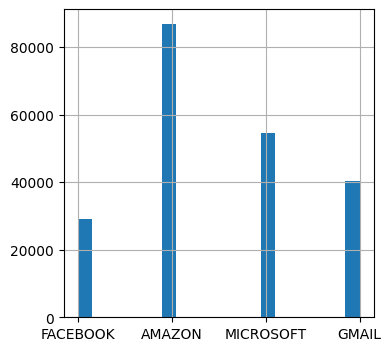

In [16]:
plt.figure(figsize=(4,4))
df['ProtocolName'].hist(bins=20)
plt.show()

How is the duration distributed?

<Axes: >

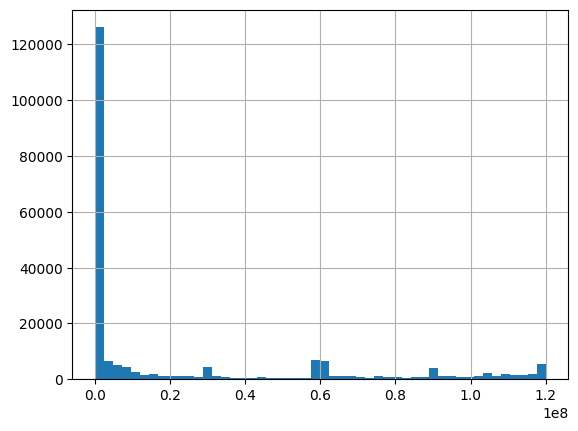

In [17]:
df['Flow.Duration'].hist(bins=50)

# PreProcessing

There would be many possible IP addresses for each record, so instead let's treat this variable as a binary indicator for internal vs external addresses

In [18]:
# Replace source & dest IPs with binary variables of "is_internal"
internal_prefixes = ['192.168','172.','10.']
df['Source.IP_internal'] = df['Source.IP'].apply(lambda ip: any([ip.startswith(prefix) for prefix in internal_prefixes]))
df['Destination.IP_internal'] = df['Destination.IP'].apply(lambda ip: any([ip.startswith(prefix) for prefix in internal_prefixes]))
df = df.drop(['Source.IP','Destination.IP'], axis=1)

Since we'll be using NMF, it's a good idea to replace missing values that are marked with '-1' with '0' instead, especially since in that column there are no 0 values that are valid

In [19]:
df.loc[df['Init_Win_bytes_backward'] == -1, 'Init_Win_bytes_backward'] = 0 # Replace -1 with 0's for missing values

We've seen the classes are highly imbalance, let's re-balance by undersampling in order to prevent from one cluster dominating the others in our model

In [20]:
min_class_size = df.groupby('ProtocolName').count().min().iloc[0]
min_class_size

np.int64(29033)

In [21]:
max_class_size = 10_000

subsample_size = min(max_class_size, min_class_size)

In [22]:
subsample_size

10000

In [23]:
dfs = []
for cl in df['ProtocolName'].unique():
    class_sample = df[df['ProtocolName'] == cl].sample(n=subsample_size)
    dfs += [class_sample]

In [24]:
df = pd.concat(dfs)

In [25]:
df = df.reset_index().drop('index', axis=1)

Feature selection using correlations protocol name as the features basis for prediction

In [26]:
df_cat = pd.concat([pd.get_dummies(df['ProtocolName']), df.drop('ProtocolName',axis=1)], axis=1)
key_fields = df_cat.corr().loc[list(set(df_cat.columns)-set(apps)), apps].max(axis=1).sort_values(ascending=False).head(20).index
key_fields

Index(['Bwd.IAT.Total', 'Idle.Max', 'Bwd.IAT.Max', 'Idle.Mean',
       'SYN.Flag.Count', 'Fwd.PSH.Flags', 'Idle.Min', 'min_seg_size_forward',
       'Fwd.IAT.Total', 'Destination.IP_internal', 'Flow.Duration', 'Idle.Std',
       'Bwd.IAT.Std', 'Flow.IAT.Min', 'Bwd.Packet.Length.Std',
       'Packet.Length.Std', 'Bwd.Packet.Length.Mean', 'Avg.Bwd.Segment.Size',
       'Bwd.Packet.Length.Max', 'Packet.Length.Variance'],
      dtype='object')

In [27]:
#X = df.drop('ProtocolName', axis=1) # Using all features
X = df[key_fields] # Using selected features only
y = list(df['ProtocolName'].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [28]:
# scaler = RobustScaler(with_centering=False) # Disabled centering to avoid negative values for NMF
#scaler = MinMaxScaler()
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Model Training

Initially I tried reducing to principal components before clustering, this degraded the results (although above 90% of the variance was captured in as few as 10 components) so we will not use it in the final version

In [29]:
pca = PCA(n_components=10)
pca.fit(X_train)
print(pca.explained_variance_ratio_.sum())

0.9684714412775455


In [30]:
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

## DBSCAN
### Hyperparameters tuning

Testing eps values:   0%|          | 0/5 [00:00<?, ?it/s]

Testing min_samples:   0%|          | 0/5 [00:00<?, ?it/s]

eps: 0.1, min_samples: 5, ARI: 0.10001382266507312


Testing min_samples:   0%|          | 0/5 [00:00<?, ?it/s]

Testing min_samples:   0%|          | 0/5 [00:00<?, ?it/s]

Testing min_samples:   0%|          | 0/5 [00:00<?, ?it/s]

Testing min_samples:   0%|          | 0/5 [00:00<?, ?it/s]

Best Parameters: {'eps': np.float64(0.1), 'min_samples': np.int64(5)}
Best ARI Score: 0.10001382266507312


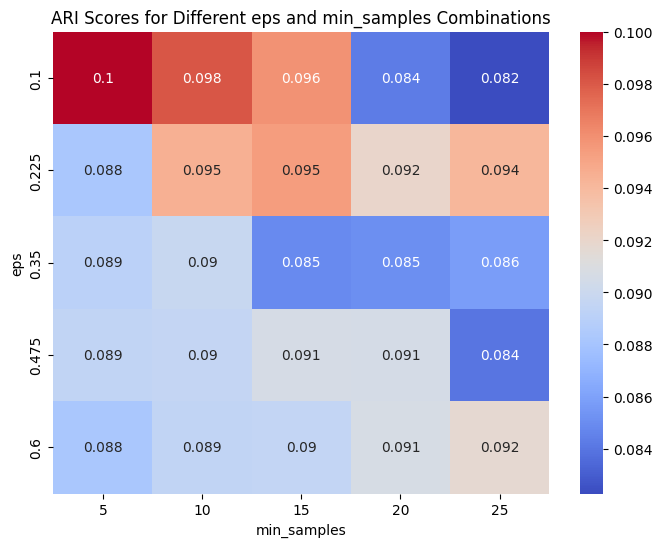

In [31]:
eps_values = np.linspace(0.1, 0.6, 5)
min_samples_values = np.arange(5, 30, 5)

best_ari = -1
best_params = {}
ari_scores = []

for eps in tqdm(eps_values, desc="Testing eps values", position=0, leave=True):
    ari_row = []
    for min_samples in tqdm(min_samples_values, desc="Testing min_samples", position=1, leave=False):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        y_pred = dbscan.fit_predict(X_train)
        ari = adjusted_rand_score(y_train, y_pred)
        ari_row.append(ari)

        # Update the best ARI score and parameters if the current ARI is better
        if ari > best_ari:
            best_ari = ari
            best_params = {'eps': eps, 'min_samples': min_samples}
            print(f"eps: {eps}, min_samples: {min_samples}, ARI: {ari}")

    
    ari_scores.append(ari_row)

# Print the best parameters and the best ARI score
print(f"Best Parameters: {best_params}")
print(f"Best ARI Score: {best_ari}")

ari_scores = np.array(ari_scores)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(ari_scores, annot=True, cmap='coolwarm', xticklabels=min_samples_values, yticklabels=eps_values)

# Labels and title
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.title('ARI Scores for Different eps and min_samples Combinations')

# Display the plot
plt.show()


In [32]:
model = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'], metric='euclidean')
y_pred = dbscan.fit_predict(X_train)

In [33]:
# model = KMeans(n_clusters=len(df['ProtocolName'].unique()))
# y_pred = np.argmax(model.fit_transform(X_train), axis=1)

In [34]:
# model = NMF(n_components=len(df['ProtocolName'].unique()))
# W = model.fit_transform(X_train)
# y_pred = W.argmax(axis=1)

### Evaluation

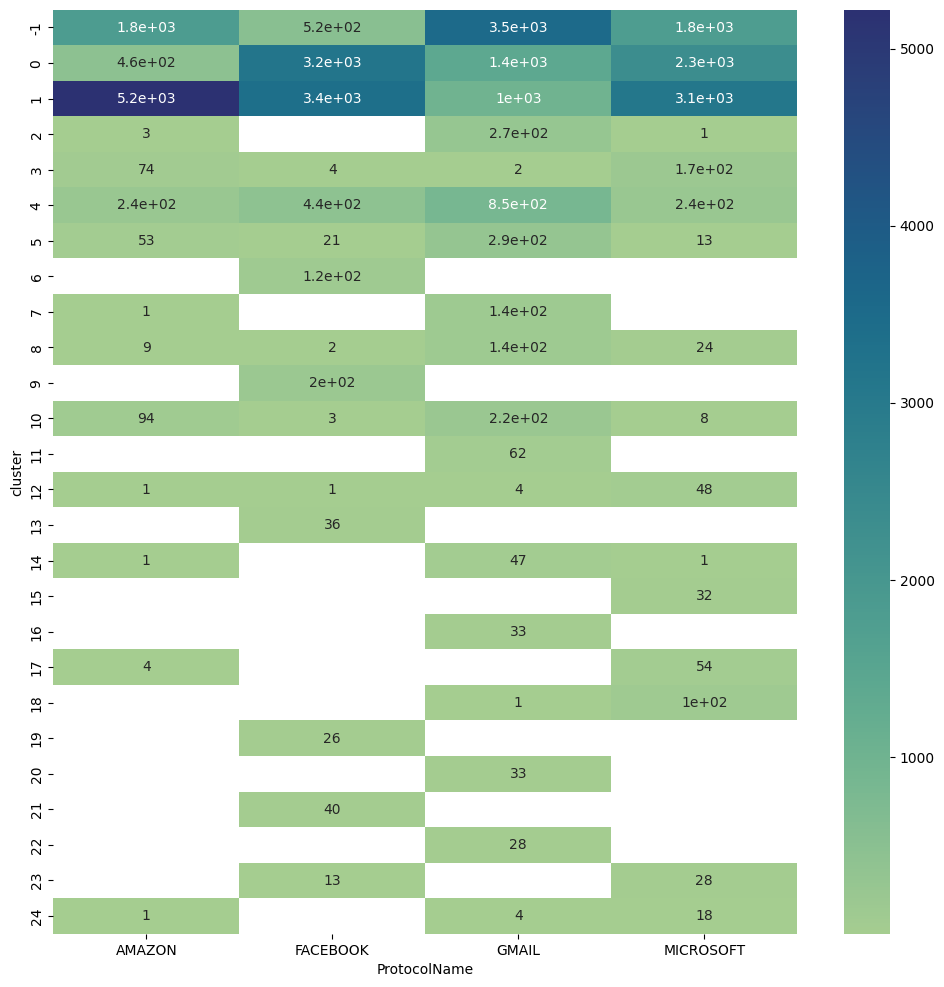

In [35]:
cluster_results = pd.concat([pd.Series(y_train, name='ProtocolName'), pd.Series(y_pred, name='cluster').reset_index(drop=True)], axis=1, ignore_index=False)
cluster_proto_counts = pd.DataFrame(cluster_results.groupby('cluster')['ProtocolName'].value_counts()).reset_index().pivot(index='cluster', columns='ProtocolName', values='count')

plt.figure(figsize=(12,12))
sns.heatmap(cluster_proto_counts, cmap='crest', annot=True)
plt.show()

In [36]:

def quant_metrics(true_labels, predicted_labels):
    ari = adjusted_rand_score(true_labels, predicted_labels)
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
    
    v_measure = v_measure_score(true_labels, predicted_labels)
    print(f"V-Measure: {v_measure:.4f}")
    
    fmi = fowlkes_mallows_score(true_labels, predicted_labels)
    print(f"Fowlkes-Mallows Index (FMI): {fmi:.4f}")
    
    homogeneity = homogeneity_score(true_labels, predicted_labels)
    completeness = completeness_score(true_labels, predicted_labels)
    print(f"Homogeneity: {homogeneity:.4f}")
    print(f"Completeness: {completeness:.4f}")
    

In [37]:
true_labels = cluster_results.iloc[:,0]
predicted_labels = cluster_results.iloc[:,1]
quant_metrics(true_labels, predicted_labels)

Adjusted Rand Index (ARI): 0.0917
Normalized Mutual Information (NMI): 0.1424
V-Measure: 0.1424
Fowlkes-Mallows Index (FMI): 0.3284
Homogeneity: 0.1542
Completeness: 0.1323


## Test set

By inspecting which classes were put in which clusters, we can determine the quality of our clustering results

In [38]:
cluster_results

,ProtocolName,cluster
0,GMAIL,0
1,FACEBOOK,0
2,AMAZON,1
3,AMAZON,-1
4,FACEBOOK,-1
...,...,...
31995,FACEBOOK,1
31996,GMAIL,-1
31997,GMAIL,1
31998,FACEBOOK,1


In order to evaluate with the test set, we will classify each new data point according to the majority class labels that is in its corresponding cluster (which was calculated with the training set)

In [39]:
X_test = scaler.fit_transform(X_test)
y_test_pred = model.fit_predict(X_test)


cluster_protocol_map = cluster_results.groupby('cluster')['ProtocolName'].agg(lambda x: x.mode()[0]).to_dict()
y_test_pred = [(cluster_protocol_map[y]  if y in cluster_protocol_map else 'None') for y in y_test_pred]

In [40]:
accuracy_score(y_test_pred, y_test)

0.2505

Using this method achieved poor accuracy, it's pretty bad overall and it might be because our data requires a model that is more complex and can work with dependent features as well

## HDBSCAN

In [41]:
model = HDBSCAN(min_cluster_size=20)
y_pred = model.fit_predict(X_train)

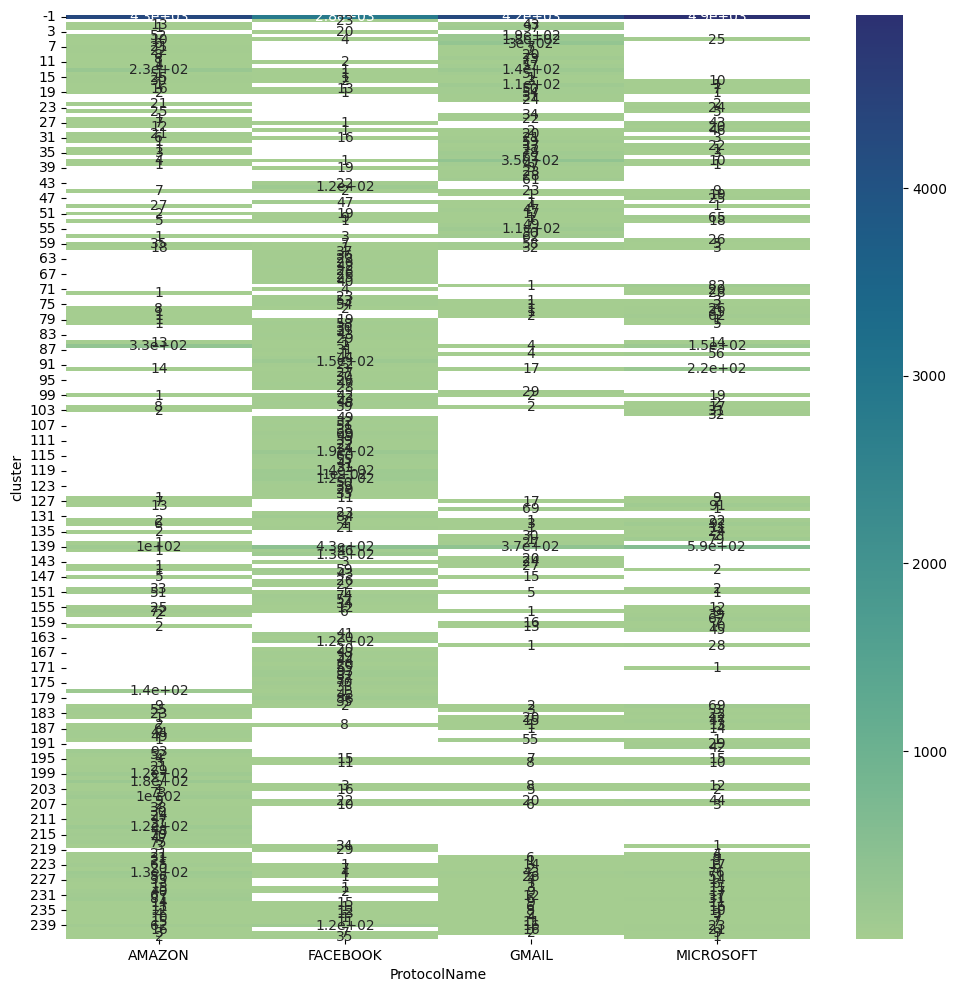

In [42]:
cluster_results = pd.concat([pd.Series(y_train, name='ProtocolName'), pd.Series(y_pred, name='cluster').reset_index(drop=True)], axis=1, ignore_index=False)
cluster_proto_counts = pd.DataFrame(cluster_results.groupby('cluster')['ProtocolName'].value_counts()).reset_index().pivot(index='cluster', columns='ProtocolName', values='count')

plt.figure(figsize=(12,12))
sns.heatmap(cluster_proto_counts, cmap='crest', annot=True)
plt.show()

In [43]:
true_labels = cluster_results.iloc[:,0]
predicted_labels = cluster_results.iloc[:,1]
quant_metrics(true_labels, predicted_labels)

Adjusted Rand Index (ARI): 0.0170
Normalized Mutual Information (NMI): 0.2120
V-Measure: 0.2120
Fowlkes-Mallows Index (FMI): 0.2690
Homogeneity: 0.3467
Completeness: 0.1526


In [44]:
X_test = scaler.fit_transform(X_test)
y_test_pred = model.fit_predict(X_test)


cluster_protocol_map = cluster_results.groupby('cluster')['ProtocolName'].agg(lambda x: x.mode()[0]).to_dict()
y_test_pred = [(cluster_protocol_map[y]  if y in cluster_protocol_map else 'None') for y in y_test_pred]

In [45]:
accuracy_score(y_test_pred, y_test)

0.277375

## Comparison to Supervised Learning (RandomForest)

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import joblib

In [47]:


# Define the model and parameter grid
model = RandomForestClassifier()
param_grid = {
    #'ccp_alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0],
    'n_estimators': np.arange(100, 500, 100),
}

# Create GridSearchCV instance
gridsearch = GridSearchCV(
    model, 
    verbose=1, 
    cv=3, 
    param_grid=param_grid
)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': array([100, 200, 300, 400])},
             verbose=1)

In [48]:
model = gridsearch.best_estimator_

In [49]:
pred_y = model.predict(X_test)
accuracy_score(pred_y, y_test)

0.682625

It seems like the supervised learning approach works better for this type of data, with 200 trees we got to 68% accuracy.
Let's end up by inspecting which of the features were the most influential

In [50]:
pd.DataFrame(zip(key_fields,model.feature_importances_), columns=['feature','importance']).sort_values('importance', ascending=False)

,feature,importance
0,Bwd.IAT.Total,0.107092
10,Flow.Duration,0.096933
8,Fwd.IAT.Total,0.089862
13,Flow.IAT.Min,0.085317
2,Bwd.IAT.Max,0.077198
18,Bwd.Packet.Length.Max,0.075112
12,Bwd.IAT.Std,0.057953
19,Packet.Length.Variance,0.051955
15,Packet.Length.Std,0.051648
9,Destination.IP_internal,0.048314


### Confusion Matrix

In [62]:
confusion_matrix(pred_y, y_test)

array([[1079,  186,  152,  325],
       [  30, 1480,    8,  107],
       [  85,   21, 1417,  109],
       [ 809,  335,  372, 1485]])

# Conclusions
It seems like this kind of data is not easily seperatable by unsupervised methods, we have examined mainly density based clustering here and these showed poor results, in addition I have inspected KMeans and NMF as well and they showed even worse results and thus were not included here.
What did work somewhat decently was going with supervised approach using random forest ensemble.
This could be due to the complexity of the data, maybe the dependence between some of the features requires a more sophisticated model, and separating the data points in latent space is not enough.